# README

Welcome!

In this script, we implement hyper-learning to perform gradient-based adaptation of the batch size in line with our paper (...). 

The notebook provides a walkthrough style format that has been written to be as plug-and-play as possible - you are mostly likely interested in running experiments after all! 

For this reason, the only thing you'll need to do to get the experiments underway is to change the root_path and save directories to match your own Google Drive, and that's it! Simply head to the 'run' section to create the directories and start training. 

If you are also interested in learning more about the various components of the code (e.g. architecture for Arbiter, optimisation routines, linear mapping to feature space, etc), you'll find descriptions at each respective section.

Happy experimenting!

(p.s. please get in touch at ... if there are any issues with the code).

# Import g-drive

In [8]:
from google.colab import drive
drive.mount('/content/gdrive/')
root_path  = 'gdrive/My Drive/ho/hyperlearning/batch-size'


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


GPU info

In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 10 11:48:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# dataset.py

In [3]:

import os 
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_loc = '/data'

def get_dataloaders(dataset, batch_size, train_percent=0.8):
  if dataset == 'mnist':
      return mnist_data_loader(batch_size, train_percent)
  elif dataset == 'svhn':
      return svhn_data_loader(batch_size, train_percent)
  elif dataset == 'cifar_10':
      return cifar_10_data_loader(batch_size, train_percent)
  elif dataset == 'cifar_100':
      return cifar_100_data_loader(batch_size, train_percent)
  else:
      raise Exception('dataset is not supported')

def mnist_data_loader(batch_size, train_percent):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  
  ''' datasets
  '''
  train_dataset = datasets.MNIST(root=data_loc, train=True, download=True, transform=transform)
  test_dataset = datasets.MNIST(root=data_loc, train=False, transform=transform, )
  
  ''' dataloaders 
  '''
  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(train_percent * num_train))
  # training
  train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:split]),
    pin_memory=False, num_workers=1) 
  # validation data
  val_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[split:num_train]),
    pin_memory=False, num_workers=1)
  # test data 
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=1)

  custom_loader = CustomDataLoader(train_dataset, transform, train_percent)

  return {'train':train_loader, 'val':val_loader, 'test':test_loader, 'custom':custom_loader}
  
def svhn_data_loader(batch_size, train_percent):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  
  ''' datasets
  '''
  train_dataset = datasets.SVHN(root=data_loc, split='train', download=True, transform=transform)
  test_dataset = datasets.SVHN(root=data_loc, split='test', transform=transform)

  ''' dataloaders 
  '''
  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(train_percent * num_train))
  # training
  train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:split]),
    pin_memory=False, num_workers=1) 
  # validation data
  val_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[split:num_train]),
    pin_memory=False, num_workers=1)
  # test data 
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=1)

  custom_loader = CustomDataLoader(train_dataset, transform, train_percent)

  return {'train':train_loader, 'val':val_loader, 'test':test_loader, 'custom':custom_loader}
  
def cifar_10_data_loader(batch_size, train_percent):
  # transforms
  transform_train = transforms.Compose(
      [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), ])
  transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(
      (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), ])
  
  # datasets
  train_dataset = datasets.CIFAR10(root=data_loc, train=True, download=True, transform=transform_train)
  test_dataset = datasets.CIFAR10(root=data_loc, train=False, transform=transform_test)
  
  # dataloaders with validation/hessian subsets of the training dataset
  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(train_percent * num_train))

  train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:split]),
    pin_memory=False, num_workers=1) 

  # validation data
  val_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[split:num_train]),
    pin_memory=False, num_workers=1)

  # test data 
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=1)

  custom_loader = CustomDataLoader(train_dataset, transform_train, train_percent)

  return {'train':train_loader, 'val':val_loader, 'test':test_loader, 'custom':custom_loader}
  

def cifar_100_data_loader(batch_size, train_percent):
  transform_train = transforms.Compose(
      [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)), ])
  transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(
      (0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)), ])
  
  '''datasets '''
  train_dataset = datasets.CIFAR100(root=data_loc, train=True, download=True, transform=transform_train)
  test_dataset = datasets.CIFAR100(root=data_loc, train=False, transform=transform_test)

  ''' dataloaders '''
  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(train_percent * num_train))

  train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:split]),
    pin_memory=True, num_workers=1) 

  # validation data
  val_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[split:num_train]),
    pin_memory=True, num_workers=1)

  # test data 
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=1)
  
  custom_loader = CustomDataLoader(train_dataset, transform_train, train_percent)

  return {'train':train_loader, 'val':val_loader, 'test':test_loader, 'custom':custom_loader}
  

# custom_dataloader.py

In [4]:


'''
@started: 17/11/21
@author: calmac
'''

import os 
import numpy as np
from PIL import Image
import torch
from torchvision import datasets, transforms
from torch.utils import data 

class CustomDataLoader(object):
  
    def __init__(self, dataset, transform, split):

        self.num_train = len(dataset)
        self.val_start = int(np.floor(split * self.num_train))
        self.data = dataset.data
        self.targets = dataset.targets
        self.transform = transform

    def __call__(self, sample_size):

        
        idx = list(np.random.randint(low=self.val_start, high=self.num_train, size=sample_size))
        
        X = np.array([self.data[i] for i in idx])
        labels = torch.from_numpy(np.array([self.targets[i] for i in idx]))

        for i in range(sample_size):
          xi = Image.fromarray(X[i,:])
          xi = self.transform(xi).unsqueeze(0)
          if i==0:
            inputs = xi
          else:
            inputs = torch.cat((inputs,xi), dim=0)

        return inputs, labels


# hd.py

In [ ]:
import math
import torch
from torch.optim.optimizer import Optimizer,required
from functools import reduce


class SGDHD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).
    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
        hypergrad_lr (float, optional): hypergradient learning rate for the online
        tuning of the learning rate, introduced in the paper
        `Online Learning Rate Adaptation with Hypergradient Descent`_
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf
    .. _Online Learning Rate Adaptation with Hypergradient Descent:
        https://openreview.net/forum?id=BkrsAzWAb
    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.
        Considering the specific case of Momentum, the update can be written as
        .. math::
                  v = \rho * v + g \\
                  p = p - lr * v
        where p, g, v and :math:`\rho` denote the parameters, gradient,
        velocity, and momentum respectively.
        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form
        .. math::
             v = \rho * v + lr * g \\
             p = p - v
        The Nesterov version is analogously modified.
    """

    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, hypergrad_lr=0, results_files=None):
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov, hypergrad_lr=hypergrad_lr)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGDHD, self).__init__(params, defaults)

        if len(self.param_groups) != 1:
            raise ValueError("SGDHD doesn't support per-parameter options (parameter groups)")

        self._params = self.param_groups[0]['params']
        self._params_numel = reduce(lambda total, p: total + p.numel(), self._params, 0)

        self.results_files = results_files

    def _gather_flat_grad_with_weight_decay(self, weight_decay=0):
        views = []
        for p in self._params:
            if p.grad is None:
                view = torch.zeros_like(p.data)
            elif p.grad.data.is_sparse:
                view = p.grad.data.to_dense().view(-1)
            else:
                view = p.grad.data.view(-1)
            if weight_decay != 0:
                view.add_(weight_decay, p.data.view(-1))
            views.append(view)
        return torch.cat(views, 0)

    def _add_grad(self, step_size, update):
        offset = 0
        for p in self._params:
            numel = p.numel()
            # view as to avoid deprecated pointwise semantics
            p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))
            offset += numel
        assert offset == self._params_numel

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        assert len(self.param_groups) == 1

        loss = None
        if closure is not None:
            loss = closure()

        group = self.param_groups[0]
        weight_decay = group['weight_decay']
        momentum = group['momentum']
        dampening = group['dampening']
        nesterov = group['nesterov']

        grad = self._gather_flat_grad_with_weight_decay(weight_decay)

        # NOTE: SGDHD has only global state, but we register it as state for
        # the first param, because this helps with casting in load_state_dict
        state = self.state[self._params[0]]
        # State initialization
        if len(state) == 0:
            state['grad_prev'] = torch.zeros_like(grad)

        grad_prev = state['grad_prev']
        # Hypergradient for SGD
        h = torch.dot(grad, grad_prev)
        # Hypergradient descent of the learning rate:
        group['lr'] += group['hypergrad_lr'] * h
        write_results('{}'.format(h.item()), self.results_files['h'])
        write_results('{}'.format(group['lr'].data), self.results_files['lrit'])

        if momentum != 0:
            if 'momentum_buffer' not in state:
                buf = state['momentum_buffer'] = torch.zeros_like(grad)
                buf.mul_(momentum).add_(grad)
            else:
                buf = state['momentum_buffer']
                buf.mul_(momentum).add_(1 - dampening, grad)
            if nesterov:
                grad.add_(momentum, buf)
            else:
                grad = buf

        state['grad_prev'] = grad

        self._add_grad(-group['lr'], grad)

        return loss


class AdamHD(Optimizer):
    """Implements Adam algorithm.

    It has been proposed in `Adam: A Method for Stochastic Optimization`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        hypergrad_lr (float, optional): hypergradient learning rate for the online
        tuning of the learning rate, introduced in the paper
        `Online Learning Rate Adaptation with Hypergradient Descent`_

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Online Learning Rate Adaptation with Hypergradient Descent:
        https://openreview.net/forum?id=BkrsAzWAb
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, hypergrad_lr=1e-8, results_files=None):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, hypergrad_lr=hypergrad_lr)
        super(AdamHD, self).__init__(params, defaults)
        
        self.results_files = results_files

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                if state['step'] > 1:
                    prev_bias_correction1 = 1 - beta1 ** (state['step'] - 1)
                    prev_bias_correction2 = 1 - beta2 ** (state['step'] - 1)
                    # Hypergradient for Adam:
                    h = torch.dot(grad.view(-1), torch.div(exp_avg, exp_avg_sq.sqrt().add_(group['eps'])).view(-1)) * math.sqrt(prev_bias_correction2) / prev_bias_correction1
                    # Hypergradient descent of the learning rate:
                    group['lr'] += group['hypergrad_lr'] * h
                    write_results('{}'.format(h.item()), self.results_files['h'])
                    write_results('{}'.format(group['lr'].data), self.results_files['lrit'])
                
                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

# network.py

In [5]:


'''
@author: calmac
@started: 13/10/21

'''

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

def get_network(network_name, dataset):
    if dataset == 'mnist':
        return network(network_name, num_classes=10, num_channels=1)
    elif dataset == 'svhn':
        return network(network_name, num_classes=10, num_channels=3)
    elif dataset == 'cifar_10':
        return network(network_name, num_classes=10, num_channels=3)
    elif dataset == 'cifar_100':
        return network(network_name, num_classes=100, num_channels=3)
    else:
        raise Exception('dataset is not supported')


def network(network_name, num_classes, num_channels):
    # Wide ResNet
    if network_name == 'wrn':
        return wide_resnet_16_4(num_classes)  
    # VGG
    elif network_name == 'vgg':
        return vgg11_bn(num_classes)
    else:
        raise Exception('network is not supported')


"""
===============================
Wide ResNets 
===============================
Reimplementation of https://github.com/meliketoy/wide-resnet.pytorch
"""

class WideResNet(nn.Module):

    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(WideResNet, self).__init__()

        self.in_planes = 16
        
        assert (int((depth - 4) % 6) == 0), 'Wide-resnet depth should be 6n+4'
        n = int((depth - 4) / 6)
        k = widen_factor

        n_stages = [16, 16 * k, 32 * k, 64 * k]

        self.conv1 = conv3x3(3, n_stages[0])
        self.layer1 = self._wide_layer(WideBasicBlock, n_stages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(WideBasicBlock, n_stages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(WideBasicBlock, n_stages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(n_stages[3], momentum=0.9)
        self.fc = nn.Linear(n_stages[3], num_classes)
        
        self.n_features = n_stages[3]

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x, hparam=None):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        x = out.view(out.size(0), -1)
        if hparam is not None:
            assert x.size() == hparam.size(), 'size mismatch'
            r = x.data*hparam 
            x += r
        x = self.fc(x)
        return x


class WideBasicBlock(nn.Module):

    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=False)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)
        return out


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def wide_resnet_16_4(num_classes, dropout=0.0):
    return WideResNet(16, 4, dropout, num_classes)

def wide_resnet_28_10(num_classes, dropout=0.0):
    return WideResNet(28, 10, dropout, num_classes)

def wide_resnet_28_20(num_classes, dropout=0.0):
    return WideResNet(28, 20, dropout, num_classes)



'''
===============================
VGG 
===============================
'''

class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features, num_classes):
        super(VGG, self).__init__()
        
        self.features = features
        self.n_features = 512
        
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes), 
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x, hparam=None):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        if hparam is not None:
            r = x.data*hparam
            x += r 
        x = self.fc(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
          512, 512, 512, 512, 'M'],
}


def vgg11(num_classes):
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']), num_classes)


def vgg11_bn(num_classes):
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True), num_classes)


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))




''' LeNet: for MNIST and SVHN.
'''
class LeNet(nn.Module):

    def __init__(self, num_classes, num_channels=1):
        super(LeNet, self).__init__()
        if num_channels == 1:
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 50, 5)
            self.fc1 = nn.Linear(4 * 4 * 50, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)
        else:
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x, hparam=None):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)

        if hparam is not None:
            r = out.data*hparam
            out += r 

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

def lenet_5(num_classes, num_channels):
    return LeNet(num_classes, num_channels)


''' Multilayer perceptron: for MNIST and SVHN.
'''
class MLP(nn.Module):

    def __init__(self, num_classes, n_1, n_2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, n_1)
        self.fc2 = nn.Linear(n_1, n_2)
        self.fc3 = nn.Linear(n_2, num_classes)
        self.n_features = n_2
        
    def forward(self, x, hparam=None):
        x = x.view(-1, 28 * 28)
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        if hparam is not None:
          r = out.data*hparam
          out += r
        return self.fc3(dout)


def mlp(num_classes=10, n_1=512, n_2=256):
    return MLP(num_classes, n_1, n_2)


tensor(99.5000)
tensor(999.9963, dtype=torch.float64)
tensor(999.9955, dtype=torch.float64)
tensor(999.9945, dtype=torch.float64)
tensor(999.9932, dtype=torch.float64)
tensor(999.9917, dtype=torch.float64)
tensor(999.9898, dtype=torch.float64)
tensor(999.9876, dtype=torch.float64)
tensor(999.9848, dtype=torch.float64)
tensor(999.9814, dtype=torch.float64)
tensor(999.9772, dtype=torch.float64)
tensor(999.9721, dtype=torch.float64)
tensor(999.9659, dtype=torch.float64)
tensor(999.9583, dtype=torch.float64)
tensor(999.9489, dtype=torch.float64)
tensor(999.9375, dtype=torch.float64)
tensor(999.9235, dtype=torch.float64)
tensor(999.9063, dtype=torch.float64)
tensor(999.8854, dtype=torch.float64)
tensor(999.8597, dtype=torch.float64)
tensor(999.8283, dtype=torch.float64)
tensor(999.7899, dtype=torch.float64)
tensor(999.7429, dtype=torch.float64)
tensor(999.6853, dtype=torch.float64)
tensor(999.6149, dtype=torch.float64)
tensor(999.5287, dtype=torch.float64)
tensor(999.4233, dtype=torch.float

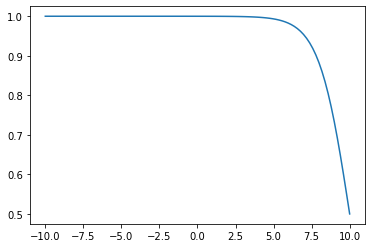

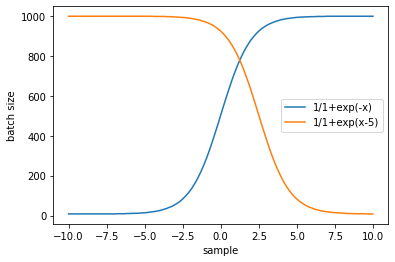

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn

criterion = nn.SmoothL1Loss()
label = torch.tensor(float(200))
pred = torch.tensor(float(100))
loss = criterion(pred, label)
print(loss)


x = np.linspace(-10, 10,100)
x = torch.tensor(x)
y_torch = torch.sigmoid(-x+10)
fig1 = plt.figure()
plt.plot(x, y_torch)

def ctbs1(s, B_min=8, B_max=1000):
    B = (B_max - B_min)*torch.sigmoid(s) + B_min
    return int(np.floor(B.item()))

def ctbs2(s, B_min=8, B_max=1000, warmup=False):
    B = (B_max - B_min)*torch.sigmoid(-s+2.5) + B_min
    print(B)
    # if warmup:
    # else:
    return int(np.floor(B.item()))

b1 = np.array([ctbs1(i) for i in x])
b2 = np.array([ctbs2(i) for i in x])

fig2 = plt.figure()
plt.plot(x,b1)
plt.plot(x,b2)
plt.xlabel('sample')
plt.ylabel('batch size')
plt.legend([r'1/1+exp(-x)',r'1/1+exp(x-5)'])
# s = torch.tensor(float(10))
# B = ctbs()
# plot()


def stable_sigmoid(x):
    sig = 1/(1 + np.exp(-x))
    # sig = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return sig

def logit(y, eps=1e-4):
    if y == 0:
      y+=eps
    elif y==1:
      y-=eps      
    return np.log(y) - np.log(1-y)

# x = np.linspace(-100,100,100)
# print(x)
# y = stable_sigmoid(x)
# print(y)
# plot(x,y)

# z = np.array([logit(i) for i in y])
# print(z)

# utils.py

In [6]:


import math
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as ag
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

def warmup(scheduler, optimiser, dataloaders, save=False):
    print('\nwarming up...')
    s_target = dataloaders['train'].batch_size
    huber = nn.SmoothL1Loss().cuda()
    temp_hyperlr = 1e-4
    optimiser.param_groups[0]['lr'] = optimiser.param_groups[1]['lr'] = temp_hyperlr
    l_init = ctl(s_target).cuda() 
    print(l_init) 
    scheduler.train()
    for j in range(10000): # arbitrarily high iteration length: usually only takes around 1 to 2 epochs (2000 iters at most)
        # inputs, _ = next(iter(dataloaders['val']))
        inputs = torch.randn(s_target, 3, 32, 32)
        optimiser.zero_grad()
        logits, l_alpha, S_alpha, _ = scheduler(inputs.cuda(), warmup=True)
        distance = huber(l_alpha, l_init)
        # print(distance)
        distance.backward()
        optimiser.step()
        print(S_alpha)
        if np.abs(S_alpha - s_target) < 2:
            if save:
                torch.save(scheduler.state_dict(), 
                  os.path.join(root_path, './warmedUp_scheduler_s={}.pth.tar'.format(batch_size))
                )
            optimiser.param_groups[0]['lr'] = phi_lr
            optimiser.param_groups[1]['lr'] = alpha_lr
            optimiser.param_groups[1]['params'] = scheduler.alpha_params(reset=True)
            break
    assert optimiser.param_groups[0]['lr'] == phi_lr, 'Phi has the wrong hyper lr.'
    assert optimiser.param_groups[1]['lr'] == alpha_lr, 'Alpha has the wrong hyper lr.'
    if any(abs(optimiser.param_groups[1]['params'][0]) > 1e-4) == True:
        raise AssertionError ('alphas havent been reset. Make sure they are before starting training.')

# def warmup(scheduler, optimiser, dataloaders, save=False):
#     print('\nwarming up...')
#     B_init = dataloaders['train'].batch_size
#     B_init = torch.tensor(float(B_init)).cuda()
#     huber = nn.SmoothL1Loss().cuda()
#     temp_hyperlr = 1e-4
#     optimiser.param_groups[0]['lr'] = optimiser.param_groups[1]['lr'] = temp_hyperlr
#     scheduler.train()
#     for j in range(10000): # arbitrarily high iteration length: usually only takes around 1 to 2 epochs (2000 iters at most)
#         inputs, _ = next(iter(dataloaders['val']))
#         optimiser.zero_grad()
#         logits, l_alpha, B_pred = scheduler(inputs.cuda(), warmup=True)
#         # print(B_pred)
#         distance = huber(B_pred, B_init)
#         distance.backward()
#         optimiser.step()
#         # print(S_alpha)
#         if torch.abs(B_pred - B_init) < 1:
#             if save:
#                 torch.save(scheduler.state_dict(), 
#                   os.path.join(root_path, './warmedUp_scheduler_s={}.pth.tar'.format(dataloaders['train'].batch_size))
#                 )
#             optimiser.param_groups[0]['lr'] = phi_lr
#             optimiser.param_groups[1]['lr'] = alpha_lr
#             optimiser.param_groups[1]['params'] = scheduler.alpha_params(reset=True)
#             break
#     assert optimiser.param_groups[0]['lr'] == phi_lr, 'Phi has the wrong hyper lr.'
#     assert optimiser.param_groups[1]['lr'] == alpha_lr, 'Alpha has the wrong hyper lr.'
#     if any(abs(optimiser.param_groups[1]['params'][0]) > 1e-4) == True:
#         raise AssertionError ('alphas havent been reset. Make sure they are before starting training.')


def logit(x):
    return torch.log(x) - torch.log(1-x)

def ctl(c,s_min=8,s_max=1000,eps=1e-3):
    
    bs = torch.tensor(float(c))
    if c == s_min:
        bs += eps
    elif c == s_max:
        bs -= eps
 
    return logit((bs - s_min) / (s_max - s_min))

def ctbs(l, s_min=8, s_max=1000):
    
    x = (s_max - s_min)*torch.sigmoid(l) + s_min
    return int(np.floor(x.item()))

def inv_softplus(x):
    """ Inverse softplus function: Maps x lying in (0, infty) to R"""
    return torch.log(torch.exp(x) - 1)

def bs_softplus(x, s_min=8, s_max=1000):
    x = (s_max - s_min)*nn.functional.softplus(x) + s_min
    return int(np.floor(x.item()))


# def ctbs(s, B_min=8, B_max=512, warmup=False):
#     B = (B_max - B_min)*torch.sigmoid(-s+2.5) + B_min
#     if warmup:
#       return B
#     else:
#       return int(np.floor(B.item()))

def init_weights(m):
    if type(m) == nn.Conv2d:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
    elif type(m) == nn.BatchNorm2d:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)


def count_correct(output, target):
    probs = F.softmax(output,dim=1)
    _, pred = torch.max(probs.data, 1)
    correct = (pred == target).sum().item()
    return correct

def read_results(file):
    with open(file) as f:
        array=[]
        for line in f.readlines():
            array.append(np.array(line).astype(np.float))
        f.close()
    return array


def write_csv(stuff, file, batch_size=True):
    x_np = np.array(stuff)
    x_df = pd.DataFrame(x_np)
    x_df.to_csv(file)

  
def write_dist(stuff, file):
    if len(stuff)==1:
        info = str(stuff[0])
    elif len(stuff)==4:
        info = str(stuff[0])+' '+str(stuff[1])+' '+str(stuff[2])+' '+str(stuff[3])
    elif len(stuff)==10:
        info = str(stuff[0])+' '+str(stuff[1])+' '+str(stuff[2])+' '+str(stuff[3])+' '+str(stuff[4])+' '+str(stuff[5])+' '+str(stuff[6])+' '+str(stuff[7])+' '+str(stuff[8])+' '+str(stuff[9])
    file.write(info+'\n')
    file.flush()
    
    
def write_results(stuff, file):
    file.write(stuff+'\n')
    file.flush()



def clear_grad(model):
    for p in model.parameters():
        if p.grad is not None:
            p.grad.detach()
            p.grad.zero_()


def count_params(net):
    return sum(p.numel() for p in net.parameters())/1e6





In [ ]:
x = torch.tensor(-0.5)
b = torch.nn.functional.softplus(x)
b2 = torch.sigmoid(x)
print(b)
print(b2)

print(bs_softplus(x))
print(ctbs(x))

tensor(0.4741)
tensor(0.3775)
246
198


# Arbiter.py

In [ ]:

'''
@startdate: 13/10/21.
@author: calmac
'''


import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import os 

class bsg(nn.Module):
   
    def __init__(self, n_samples, n_features, results_files):
        super(bsg, self).__init__()
        
        self.n_samples = n_samples
        self.results_files = results_files
        
        # self.loss_embedding = nn.Embedding()

        self.layer1 = nn.Sequential(
              nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0),
              nn.BatchNorm2d(64),
              nn.ReLU(inplace=True),
              )
      
        self.layer2 = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                )
        
        self.layer3 = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                )
        
        self.layer4 = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                )
        
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, self.n_samples)
        self.alphas = Variable(1e-6*torch.randn(self.n_samples).cuda(), requires_grad=True)
        self.linear = nn.Linear(1, n_features, bias=False)
        # if mapping_grads_off:
        #     for p in self.linear.parameters():
        #         p.requires_grad_(False) 

        self.reset = False
        self.im_we = torch.ones(n_samples).cuda()
        self.im_we[-1:] *= 100

    def alpha_params(self, reset=False):
       
        if reset:
            self.alphas = Variable(1e-6*torch.randn(self.n_samples).cuda(), requires_grad=True)
        return [self.alphas]

    def _transform(self, x):
        x = x.transpose(-1, -2)   
        x = torch.mean(x, dim=1)  
        x = torch.sort(x)[0]     
        return x


    def forward(self, data, warmup=False):
        
        x = self.layer1(data)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        logits = self._transform(x)
        weights = F.softmax(self.alphas, dim=-1)
        l_alpha = sum(l*w for l, w in zip(logits, weights))
        S_alpha = ctbs(l_alpha)
        batch_l = l_alpha.repeat(S_alpha, 1)
        hparam = self.linear(batch_l)
        
        if not warmup:
            write_csv([ctbs(l) for l in logits], self.results_files['samples'])
            write_csv([w.item() for w in weights], self.results_files['alpha'])
            write_results('{}'.format(l_alpha.item()), self.results_files['la'])
            write_results('{}'.format(S_alpha), self.results_files['sa'])
        
        return logits, l_alpha, S_alpha, hparam
    

# main.py

code for changing batch size at 60 epoch (Smith heuristic)
 i.e. not changed each epoch as before 

In [37]:
'''

@latestUpdate: 17/11/21
@dateStarted: 13/10/21
@author: calmac
'''
import time
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


def main(results_files):
    
    dataloaders = get_dataloaders(dataset, batch_size)
    net = get_network(arch, dataset).cuda()

    if lr_scheduler_type == 'hd':
        print('\nhd lr decay on ({}).'.format(optim_type))
        if optim_type == 'adam':
            net_optimiser = AdamHD(net.parameters(), lr=lr, weight_decay=wd, hypergrad_lr=hd_hyperlr, results_files=results_files)
        else:
            net_optimiser = SGDHD(net.parameters(), lr=lr, momentum=momentum, weight_decay=wd, hypergrad_lr=hd_hyperlr, results_files=results_files)
    else:
        if optim_type == 'adam':
          net_optimiser = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
        else:
          net_optimiser = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=wd)

        if lr_scheduler_type == 'exp':
            lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(net_optimiser, gamma=lr_decay)
        elif lr_scheduler_type == 'step':
            print('\nstep lr decay on.')
            lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(net_optimiser, milestones=milestones, gamma=lr_decay)
        elif lr_scheduler_type == 'cosine':
            print('\ncosine lr decay on.')
            lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(net_optimiser, T_0=t_0, T_mult=t_mult, eta_min=lr * 1e-2)
        elif lr_scheduler_type == 'off':
            print('\nlr decay off.')
        lr_scheduler = None

    bs_scheduler = bsg(n_samples=n_samples,n_features=net.n_features, results_files=results_files).cuda()
    print('# parameters in Arbiter: {}'.format(sum(p.numel() for p in bs_scheduler.parameters())))

    sched_optimiser = torch.optim.Adam([
                                    {'params':bs_scheduler.parameters(),   'lr':phi_lr},
                                    {'params':bs_scheduler.alpha_params(), 'lr':alpha_lr},
                                    ], weight_decay=wd)
    optimisers = {'net':net_optimiser, 'sched':sched_optimiser}

    ''' misc
    '''
    criterion = nn.CrossEntropyLoss().cuda()
    num_train = int(train_percent*len(dataloaders['train'].dataset))
    num_val = int(np.round(1-train_percent, 1)*len(dataloaders['val'].dataset)) 
    num_test = int(len(dataloaders['test'].dataset))

    ''' warmup: bring samples around current value.
    '''
    if use_warm:
        warmsched_weights = './warmedUp_scheduler_s={}.pth.tar'.format(batch_size)
        if not os.path.exists(warmsched_weights): 
            raise AssertionError('You want to use warmed up but no pretrained weights found.')
        else:
            bs_scheduler.load_state_dict(torch.load(warmsched_weights))
    else:
        warmup(bs_scheduler, sched_optimiser, dataloaders)
        print('done')

    best_acc = 0.0
    new_dataloaders = None
    scale_time = False
    turn_off = False

    write_results('{:4.6f}'.format(lr), results_files['lrit'])
    write_results('{:4.6f}'.format(lr), results_files['lrep'])
    write_results('{}'.format(batch_size), results_files['bse'])

    for epoch in range(num_epochs):

        if new_dataloaders is not None:
            dataloaders = new_dataloaders
        
        print()
        print('Epoch {} stats:'.format(epoch+1))
        
        cur_lr = net_optimiser.param_groups[0]['lr']
        cur_bs = dataloaders['train'].batch_size
        print('start of epoch lr: {}'.format(cur_lr))
        print('start of epoch BS: {}'.format(cur_bs))
        print('            LR/BS: {}'.format(cur_lr/cur_bs))
        write_results('{}'.format(cur_lr), results_files['lrep'])  
        write_results('{}'.format(cur_bs), results_files['bse'])  
        write_results('{}'.format(cur_lr/cur_bs), results_files['ratio'])  
       
        
        ''' 
        ======================
        Training epoch 
        ======================
        '''
        t_start = time.time()
        if not turn_off:
            logits, train_stats  = train(net, bs_scheduler, dataloaders, criterion, optimisers, turn_off=turn_off)
        else:
            train_stats  = train(net, bs_scheduler, dataloaders, criterion, optimisers, turn_off=turn_off)

        print('epoch took {}s'.format(time.time() - t_start))
        write_results('{}'.format(time.time() - t_start), results_files['times'])

        if lr_scheduler_type != 'hd' and lr_scheduler is not None:
          lr_scheduler.step()

        train_acc = 100. * (train_stats['correct'] / num_train)
        print(
              '\tTraining accuracy: {}/{} ({}%)'.format(
              train_stats['correct'], num_train, train_acc
              )
        )
        print('\tTraining loss: {}'.format(train_stats['loss']))
        
        ''' 
        ======================
        Validation epoch 
        ======================
        '''
        val_stats = validation(net, dataloaders['val'], criterion)
        val_acc = 100. * (val_stats['correct'] / num_val)
        print(
              '\tValidation accuracy: {}/{} ({}%)'.format(
              val_stats['correct'], num_val, val_acc
              )
        )
        print('\tValidation loss: {}'.format(val_stats['loss']))
        
        ''' 
        ======================
        Testing epoch 
        ======================
        '''
        test_stats   = test(net, dataloaders['test'], criterion)
        test_acc = 100. * (test_stats['correct'] / num_test)
        print(
              '\tTest accuracy: {}/{} ({}%)'.format(
              test_stats['correct'], num_test, test_acc
              )
        )
        print('\tTest loss: {}'.format(test_stats['loss']))

        # ''' View Arbiters progress
        # '''
        # if not turn_off:
        #     print('\nArbiters progress:')
        #     alphas = sched_optimiser.param_groups[1]['params'][0]
        #     weights = F.softmax(alphas, dim=-1)
        #     logit_best = logits[torch.max(weights, dim=0)[1]]
        #     xplus1 = ctbs(logit_best)
        #     samples = [ctbs(l) for l in logits]
        #     print('\tsamples: {}'.format(samples))
        #     print('\talphas: {}'.format([w.item() for w in weights]))
        #     print('\tbest sample: {}'.format(xplus1))
        #     write_results('{}'.format(xplus1), results_files['best'])  
        
        ''' Scheduling time 
        '''
        if not turn_off and (epoch+1) % sched_int == 0:
            alphas = sched_optimiser.param_groups[1]['params'][0]
            weights = F.softmax(alphas, dim=-1)
            logit_best = logits[torch.max(weights, dim=0)[1]]
            xplus1 = ctbs(logit_best)
            samples = [ctbs(l) for l in logits]
            print('samples: {}'.format(samples))
            print('alphas: {}'.format([w.item() for w in weights]))
            print('best sample: {}'.format(xplus1))
            new_dataloaders = get_dataloaders(dataset, batch_size=xplus1)
            assert xplus1 == new_dataloaders['train'].batch_size, 'Mismatch between batch sizes.'
            # write_results('{}'.format(xplus1), results_files['bse'])
            write_csv([ctbs(l) for l in logits], results_files['end-samples'])
            write_csv([w.item() for w in weights], results_files['end-alpha'])
            torch.save(bs_scheduler.state_dict(), 
              os.path.join(arb_dir, './arbiter_bestSample={}_epoch={}.pth.tar'.format(xplus1, epoch+1))
            )
            sched_optimiser.param_groups[1]['params'] = bs_scheduler.alpha_params(reset=True)
            
        ''' Run schedule 
        ''' 
        if bs_scheduling:
          if not smith_heuristic and (epoch+1) in bs_milestone:
            idx = bs_milestone.index(epoch+1)
            old_batch_size = dataloaders['train'].batch_size
            new_batch_size = bs[idx]
            print('batch size changed from {} to {}.'.format(old_batch_size, new_batch_size))
            new_dataloaders = get_dataloaders(dataset, batch_size=new_batch_size)
            
            ''' bring phi samples close to new batch size
            '''
            warmup(bs_scheduler, sched_optimiser, new_dataloaders) 
            print('done')


          elif smith_heuristic and (epoch+1) in smith_milestones:
            ''' implement hybrid heuristic from Smith 2018
            '''
            # batch size: only change once at 60 epochs then constant.
            if (epoch+1) == smith_milestones[0]:
              # old_batch_size = dataloaders['train'].batch_size # most recent batch size set by Arbiter
              # new_batch_size = xplus1 
              # # new_batch_size = 5*batch_size                    # scale original batch size by Smiths heuristic (x5)
              # new_dataloaders = get_dataloaders(dataset, batch_size=new_batch_size)
              # # print('batch size changed from {} to {}.'.format(old_batch_size, new_batch_size))
              print('reached epoch 60, but continuing with Arbiter....')

              ''' new idea (29/4)
                  let arbiter solve for next batch size at 60th epoch, then remove arbiter entirely and let
                  the rest of Smiths heuristic play out with that batch size.
              '''
              # turn_off = True
              # print('Arbiter turned off.')#Returned to normal training under his predicted batch size of {}.'.format(new_dataloaders['train'].batch_size))
              
              ''' newer idea (9/5/22)
                    LET Arbiter schedule the batch size until Smiths heuristic change to B at 60 epochs.
                    increase to B=640 then remove Arbiter. 
                    idea is to show that we can achieve similar dynamics and performance with even less param updates 
                    by slightly increasing B with Arbiter's heuristics.
                    THEN, read the schedule and apply to a new WRN to see if results generalise well.
              '''

            elif (epoch+1) in smith_milestones:
              # learning rate: only change at 120 and 160 (see milestones in MultiStepLR call)
              old_lr = net_optimiser.param_groups[0]['lr']
              print('old lr: {}'.format(old_lr))
              net_optimiser.param_groups[0]['lr'] *= 0.2
              # lr_scheduler.step()
              print('new lr: {}'.format(net_optimiser.param_groups[0]['lr']))
              
  
        if save_results:
            write_results('{:.6f}'.format(train_stats['loss']), results_files['trl'])
            write_results('{:.6f}'.format(train_acc), results_files['tra'])
            write_results('{:.6f}'.format(val_stats['loss']), results_files['vl'])
            write_results('{:.6f}'.format(val_acc), results_files['va'])
            write_results('{:.6f}'.format(test_stats['loss']), results_files['tel'])
            write_results('{:.6f}'.format(test_acc), results_files['tea'])
        
        if val_acc > best_acc:
            best_acc = val_acc
            print('best val acc so far: {}'.format(best_acc))
        if save_weights:
            torch.save(
              net.state_dict(), 
              os.path.join(model_dir, '{}_{}_valLoss={:4.4f}_valAcc={:4.4f}_epoch={}.pth.tar'.format(arch, dataset, val_stats['loss'], val_acc, epoch+1))
            )   
               
def train(net, bs_scheduler, dataloaders, criterion, optimisers, turn_off):
    
    net.train()   
    bs_scheduler.train()
    net_optimiser = optimisers['net']
    sched_optimiser = optimisers['sched']
    correct = 0
    loss_list = []
    
    for i, (inputs, targets) in enumerate(dataloaders['train']):

        write_results('{}'.format(dataloaders['train'].batch_size), results_files['bsi'])
        
        net_optimiser.zero_grad()
        sched_optimiser.zero_grad()
        custom_dataloader = dataloaders['custom'] 
            
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss_list.append(loss.item())
        correct += count_correct(outputs, targets)
        loss.backward()
        net_optimiser.step() 

        if not turn_off:
            val_inputs, _ = next(iter(dataloaders['val']))
            logits, l_alpha, S_alpha, hparam = bs_scheduler(val_inputs.cuda())
            ### NEW IDEA (12/7/22): condition batch size preds on current val_loss
            outputs = net(inputs)
            # info_loss = criterion(outputs, targets)
            # noise = torch.randn(dataloaders['val'].batch_size, 3, 32, 32)
            # logits, l_alpha, S_alpha, hparam = bs_scheduler(noise.cuda(), info_loss)
            new_data, new_targets = custom_dataloader(sample_size=S_alpha)
            new_data, new_targets = new_data.cuda(), new_targets.cuda()
            
            new_outputs = net(new_data, hparam=hparam)  
            # ce = criterion(new_outputs, new_targets)
            # F = ce + (ce - info_loss)
            F = criterion(new_outputs, new_targets)
            F.backward()
            sched_optimiser.step()
            write_results('{}'.format(F.item()), results_files['F'])             
        
    if not turn_off:
        return logits, {'correct': correct, 'loss': np.mean(loss_list)}
    else:
        return {'correct': correct, 'loss': np.mean(loss_list)}



def validation(net, dataloader, criterion):
    net.eval()
    correct = 0
    loss_list = []
    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            data, target = data.cuda(), target.cuda()
            output = net(data) 
            loss = criterion(output, target)
            loss_list.append(loss.item())
            correct += count_correct(output, target)
    return {'correct': correct, 'loss': np.mean(loss_list)}


def test(net, dataloader, criterion):
    net.eval()
    correct = 0
    loss_list = []
    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            data, target = data.cuda(), target.cuda()
            output = net(data) 
            loss = criterion(output, target)
            loss_list.append(loss.item())
            correct += count_correct(output, target)
    return {'correct': correct, 'loss': np.mean(loss_list)}



draft: 30/4/22

In [ ]:
# '''

# @latestUpdate: 17/11/21
# @dateStarted: 13/10/21
# @author: calmac
# '''
# import time
# import os
# import argparse
# import numpy as np
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# import torch.nn.functional as F


# def main(results_files):
#     print('wrong main')
#     dataloaders = get_dataloaders(dataset, batch_size)
#     net = get_network(arch, dataset).cuda()

#     if lr_scheduler_type == 'hd':
#         print('\nhd lr decay on ({}).'.format(optim_type))
#         if optim_type == 'adam':
#             net_optimiser = AdamHD(net.parameters(), lr=lr, weight_decay=wd, hypergrad_lr=hd_hyperlr, results_files=results_files)
#         else:
#             net_optimiser = SGDHD(net.parameters(), lr=lr, momentum=momentum, weight_decay=wd, hypergrad_lr=hd_hyperlr, results_files=results_files)
#     else:
#         if optim_type == 'adam':
#           net_optimiser = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
#         else:
#           net_optimiser = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=wd)

#         if lr_scheduler_type == 'exp':
#             lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(net_optimiser, gamma=lr_decay)
#         elif lr_scheduler_type == 'step':
#             print('\nstep lr decay on.')
#             lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(net_optimiser, milestones=milestones, gamma=lr_decay)
#         elif lr_scheduler_type == 'cosine':
#             print('\ncosine lr decay on.')
#             lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(net_optimiser, T_0=t_0, T_mult=t_mult, eta_min=lr * 1e-2)
#         elif lr_scheduler_type == 'off':
#             print('\nlr decay off.')
#         lr_scheduler = None

#     bs_scheduler = bsg(n_samples=n_samples,n_features=net.n_features, results_files=results_files).cuda()
#     print('# parameters in Arbiter: {}'.format(sum(p.numel() for p in bs_scheduler.parameters())))

#     sched_optimiser = torch.optim.Adam([
#                                     {'params':bs_scheduler.parameters(),   'lr':phi_lr},
#                                     {'params':bs_scheduler.alpha_params(), 'lr':alpha_lr},
#                                     ], weight_decay=wd)
#     optimisers = {'net':net_optimiser, 'sched':sched_optimiser}

#     ''' misc
#     '''
#     criterion = nn.CrossEntropyLoss().cuda()
#     num_train = int(train_percent*len(dataloaders['train'].dataset))
#     num_val = int(np.round(1-train_percent, 1)*len(dataloaders['val'].dataset)) 
#     num_test = int(len(dataloaders['test'].dataset))

#     ''' warmup: bring samples around current value.
#     '''
#     if use_warm:
#         warmsched_weights = './warmedUp_scheduler_s={}.pth.tar'.format(batch_size)
#         if not os.path.exists(warmsched_weights): 
#             raise AssertionError('You want to use warmed up but no pretrained weights found.')
#         else:
#             bs_scheduler.load_state_dict(torch.load(warmsched_weights))
#     else:
#         warmup(bs_scheduler, sched_optimiser, dataloaders)
#         print('done')

#     best_acc = 0.0
#     new_dataloaders = None
#     scale_time = False
#     turn_off = False

#     write_results('{:4.6f}'.format(lr), results_files['lrit'])
#     write_results('{:4.6f}'.format(lr), results_files['lrep'])
#     write_results('{}'.format(batch_size), results_files['bse'])

#     for epoch in range(num_epochs):

#         if new_dataloaders is not None:
#             dataloaders = new_dataloaders
        
#         print()
#         print('Epoch {} stats:'.format(epoch+1))
        
#         ''' 
#         ======================
#         Training epoch 
#         ======================
#         '''
#         t_start = time.time()
#         if not turn_off:
#             logits, train_stats  = train(net, bs_scheduler, dataloaders, criterion, optimisers, turn_off=turn_off)
#         else:
#             train_stats  = train(net, bs_scheduler, dataloaders, criterion, optimisers, turn_off=turn_off)

#         print('epoch took {}s'.format(time.time() - t_start))
#         write_results('{}'.format(time.time() - t_start), results_files['times'])

#         if lr_scheduler_type != 'hd' and lr_scheduler is not None:
#           lr_scheduler.step()

#         train_acc = 100. * (train_stats['correct'] / num_train)
#         print(
#               '\tTraining accuracy: {}/{} ({}%)'.format(
#               train_stats['correct'], num_train, train_acc
#               )
#         )
#         print('\tTraining loss: {}'.format(train_stats['loss']))
        
#         ''' 
#         ======================
#         Validation epoch 
#         ======================
#         '''
#         val_stats = validation(net, dataloaders['val'], criterion)
#         val_acc = 100. * (val_stats['correct'] / num_val)
#         print(
#               '\tValidation accuracy: {}/{} ({}%)'.format(
#               val_stats['correct'], num_val, val_acc
#               )
#         )
#         print('\tValidation loss: {}'.format(val_stats['loss']))
        
#         ''' 
#         ======================
#         Testing epoch 
#         ======================
#         '''
#         test_stats   = test(net, dataloaders['test'], criterion)
#         test_acc = 100. * (test_stats['correct'] / num_test)
#         print(
#               '\tTest accuracy: {}/{} ({}%)'.format(
#               test_stats['correct'], num_test, test_acc
#               )
#         )
#         print('\tTest loss: {}\n'.format(test_stats['loss']))

#         # ''' View Arbiters progress
#         # '''
#         # print('\narbiters progress:')
#         # alphas = sched_optimiser.param_groups[1]['params'][0]
#         # weights = F.softmax(alphas, dim=-1)
#         # logit_best = logits[torch.max(weights, dim=0)[1]]
#         # xplus1 = ctbs(logit_best)
#         # samples = [ctbs(l) for l in logits]
#         # print('\tsamples: {}'.format(samples))
#         # print('\talphas: {}'.format([w.item() for w in weights]))
#         # print('\tbest sample: {}'.format(xplus1))
#         # write_results('{}'.format(xplus1), results_files['best'])  

#         ''' Scheduling time 
#         '''
#         if (epoch+1) % sched_int == 0:
#             alphas = sched_optimiser.param_groups[1]['params'][0]
#             weights = F.softmax(alphas, dim=-1)
#             logit_best = logits[torch.max(weights, dim=0)[1]]
#             xplus1 = ctbs(logit_best)
#             samples = [ctbs(l) for l in logits]
#             print('samples: {}'.format(samples))
#             print('alphas: {}'.format([w.item() for w in weights]))
#             print('s for the next epoch: {}'.format(xplus1))
#             new_dataloaders = get_dataloaders(dataset, batch_size=xplus1)
#             assert xplus1 == new_dataloaders['train'].batch_size, 'Mismatch between batch sizes.'
#             # write_results('{}'.format(xplus1), results_files['bse'])
#             write_csv([ctbs(l) for l in logits], results_files['end-samples'])
#             write_csv([w.item() for w in weights], results_files['end-alpha'])
#             sched_optimiser.param_groups[1]['params'] = bs_scheduler.alpha_params(reset=True)
            
#             ''' Run schedule 
#             ''' 
#             if bs_scheduling:
#               if not smith_heuristic and (epoch+1) in bs_milestone:
#                 idx = bs_milestone.index(epoch+1)
#                 old_batch_size = dataloaders['train'].batch_size
#                 new_batch_size = bs[idx]
#                 print('batch size changed from {} to {}.'.format(old_batch_size, new_batch_size))
#                 new_dataloaders = get_dataloaders(dataset, batch_size=new_batch_size)
                
#                 ''' bring phi samples close to new batch size
#                 '''
#                 warmup(bs_scheduler, sched_optimiser, new_dataloaders) 
#                 print('done')

#                 # ''' **********
#                 # #     new idea: restart agent after heuristic change (26/4/22)
#                 # #     ********** 
#                 # # '''
#                 # # bs_scheduler = bsg(n_samples=n_samples,n_features=net.n_features, results_files=results_files).cuda()
#                 # print('NEW DYNAMICS...Arbiter has been reset.')
#                 # print('# parameters in Arbiter: {}'.format(sum(p.numel() for p in bs_scheduler.parameters())))
#                 # sched_optimiser = torch.optim.Adam([
#                 #                   {'params':bs_scheduler.parameters(),   'lr':phi_lr},
#                 #                   {'params':bs_scheduler.alpha_params(), 'lr':alpha_lr},
#                 #                   ], weight_decay=wd)
#                 # optimisers = {'net':net_optimiser, 'sched':sched_optimiser}

#                 # ''' bring phi samples close to new batch size
#                 # '''
#                 # warmup(bs_scheduler, sched_optimiser, new_dataloaders)
#                 # print('done')


#               elif smith_heuristic and (epoch+1) in smith_milestones:
#                 ''' implement hybrid heuristic from Smith 2018
#                 '''
#                 # batch size: only change once at 60 epochs then constant.
#                 if (epoch+1) == smith_milestones[0]:
#                   old_batch_size = dataloaders['train'].batch_size # most recent batch size set by Arbiter
#                   # new_batch_size = xplus1 
#                   new_batch_size = 5*batch_size                    # scale original batch size by Smiths heuristic (x5)
#                   print('batch size changed from {} to {}.'.format(old_batch_size, new_batch_size))
#                   new_dataloaders = get_dataloaders(dataset, batch_size=new_batch_size)

#                   ''' new idea (29/4)
#                       let arbiter solve for next batch size at 60th epoch, then remove arbiter entirely and let
#                       the rest of Smiths heuristic play out with that batch size.
#                   '''
#                   turn_off = True
#                   print('Arbiter turned off off. Returned to normal training under his predicted batch size of {}.'.format(dataloaders['train'].batch_size))

#                   # ''' **********
#                   #     new idea: restart agent after heuristic change (26/4/22)
#                   #     ********** 
#                   # '''
#                   # bs_scheduler = bsg(n_samples=n_samples,n_features=net.n_features, results_files=results_files).cuda()
#                   # print('NEW DYNAMICS...Arbiter has been reset.')
#                   # print('# parameters in Arbiter: {}'.format(sum(p.numel() for p in bs_scheduler.parameters())))
#                   # sched_optimiser = torch.optim.Adam([
#                   #                   {'params':bs_scheduler.parameters(),   'lr':phi_lr},
#                   #                   {'params':bs_scheduler.alpha_params(), 'lr':alpha_lr},
#                   #                   ], weight_decay=wd)
#                   # optimisers = {'net':net_optimiser, 'sched':sched_optimiser}

#                   # ''' bring phi samples close to new batch size
#                   # '''
#                   # warmup(bs_scheduler, sched_optimiser, new_dataloaders)
#                   # print('done')

#                   # ''' save all weights for quick restarts
#                   # '''
#                   # # inner system
#                   # torch.save(
#                   #     net.state_dict(), 
#                   #     os.path.join(log_root, '{}_{}_valLoss={:4.4f}_valAcc={:4.4f}_epoch={}.pth.tar'.format(arch, dataset, val_stats['loss'], val_acc, epoch+1))
#                   #   )   
                  
#                   # # outer system
#                   # torch.save(
#                   #     bs_scheduler.state_dict(), 
#                   #     os.path.join(log_root, 'scheduler_s={}_epoch={}.pth.tar'.format(new_batch_size, epoch+1))
#                   #     )
                  
#                 elif (epoch+1) in smith_milestones:
#                   # learning rate: only change at 120 and 160 (see milestones in MultiStepLR call)
#                   old_lr = net_optimiser.param_groups[0]['lr']
#                   print('old lr: {}'.format(old_lr))
#                   net_optimiser.param_groups[0]['lr'] *= 0.2
#                   # lr_scheduler.step()
#                   print('new lr: {}'.format(net_optimiser.param_groups[0]['lr']))
                  
#                   # ''' **********
#                   #     new idea: restart agent after heuristic change (26/4/22) 
#                   #     **********
#                   # '''
#                   # bs_scheduler = bsg(n_samples=n_samples,n_features=net.n_features, results_files=results_files).cuda()
#                   # print('NEW DYNAMICS...Arbiter has been reset.')
#                   # print('# parameters in Arbiter: {}'.format(sum(p.numel() for p in bs_scheduler.parameters())))
#                   # sched_optimiser = torch.optim.Adam([
#                   #                   {'params':bs_scheduler.parameters(),   'lr':phi_lr},
#                   #                   {'params':bs_scheduler.alpha_params(), 'lr':alpha_lr},
#                   #                   ], weight_decay=wd)
#                   # optimisers = {'net':net_optimiser, 'sched':sched_optimiser} 
                  
#                   # ''' bring phi samples close to new batch size
#                   # '''
#                   # warmup(bs_scheduler, sched_optimiser, new_dataloaders)
#                   # print('done')

#         ''' print stats
#         '''
#         cur_lr = net_optimiser.param_groups[0]['lr']
#         cur_bs = dataloaders['train'].batch_size
#         print('end of epoch lr: {}'.format(cur_lr))
#         print('end of epoch BS: {}'.format(cur_bs))
#         print('          LR/BS: {}'.format(cur_lr/cur_bs))
#         write_results('{}'.format(cur_lr), results_files['lrep'])  
#         write_results('{}'.format(cur_bs), results_files['bse'])  
#         write_results('{}'.format(cur_lr/cur_bs), results_files['ratio'])  
       
#         if save_results:
#             write_results('{:.6f}'.format(train_stats['loss']), results_files['trl'])
#             write_results('{:.6f}'.format(train_acc), results_files['tra'])
#             write_results('{:.6f}'.format(val_stats['loss']), results_files['vl'])
#             write_results('{:.6f}'.format(val_acc), results_files['va'])
#             write_results('{:.6f}'.format(test_stats['loss']), results_files['tel'])
#             write_results('{:.6f}'.format(test_acc), results_files['tea'])
        
#         if val_acc > best_acc:
#             best_acc = val_acc
#             print('best val acc so far: {}'.format(best_acc))
#             if save_weights:
#               torch.save(
#                 net.state_dict(), 
#                 os.path.join(model_dir, '{}_{}_valLoss={:4.4f}_valAcc={:4.4f}_epoch={}.pth.tar'.format(arch, dataset, val_stats['loss'], val_acc, epoch+1))
#               )   
               
# def train(net, bs_scheduler, dataloaders, criterion, optimisers, turn_off):
    
#     net.train()   
#     bs_scheduler.train()
#     net_optimiser = optimisers['net']
#     sched_optimiser = optimisers['sched']
#     correct = 0
#     loss_list = []
    
#     for i, (inputs, targets) in enumerate(dataloaders['train']):

#         write_results('{}'.format(dataloaders['train'].batch_size), results_files['bsi'])
        
#         net_optimiser.zero_grad()
#         sched_optimiser.zero_grad()
#         custom_dataloader = dataloaders['custom'] 
            
#         inputs, targets = inputs.cuda(), targets.cuda()
#         outputs = net(inputs)
#         loss = criterion(outputs, targets)
#         loss_list.append(loss.item())
#         correct += count_correct(outputs, targets)
#         loss.backward()
#         net_optimiser.step() 

#         if not turn_off:
#             val_inputs, _ = next(iter(dataloaders['val']))
#             logits, l_alpha, S_alpha, hparam = bs_scheduler(val_inputs.cuda())
#             new_data, new_targets = custom_dataloader(sample_size=S_alpha)
#             new_data, new_targets = new_data.cuda(), new_targets.cuda()
            
#             new_outputs = net(new_data, hparam=hparam)    
#             F = criterion(new_outputs, new_targets)
#             F.backward()
#             sched_optimiser.step()
#             write_results('{}'.format(F.item()), results_files['F'])             
        
#     if not turn_off:
#         return logits, {'correct': correct, 'loss': np.mean(loss_list)}
#     else:
#         return {'correct': correct, 'loss': np.mean(loss_list)}



# def validation(net, dataloader, criterion):
#     net.eval()
#     correct = 0
#     loss_list = []
#     with torch.no_grad():
#         for i, (data, target) in enumerate(dataloader):
#             data, target = data.cuda(), target.cuda()
#             output = net(data) 
#             loss = criterion(output, target)
#             loss_list.append(loss.item())
#             correct += count_correct(output, target)
#     return {'correct': correct, 'loss': np.mean(loss_list)}


# def test(net, dataloader, criterion):
#     net.eval()
#     correct = 0
#     loss_list = []
#     with torch.no_grad():
#         for i, (data, target) in enumerate(dataloader):
#             data, target = data.cuda(), target.cuda()
#             output = net(data) 
#             loss = criterion(output, target)
#             loss_list.append(loss.item())
#             correct += count_correct(output, target)
#     return {'correct': correct, 'loss': np.mean(loss_list)}



# setup

In [12]:
arch='vgg'
dataset='cifar_10'
num_epochs=10
batch_size=128
optim_type='sgd'
lr_scheduler_type='off'
hd_hyperlr=1e-3
lr=0.1
lr_decay=0.2
milestones=[50, 75]
t_0=10
t_mult=2
momentum=0.9
wd=5e-4
alpha_lr=1e-6   # use 1e-4 for next bs scheduling exp (too committed!: do 1e-5 again); 1e-5 for next lr exp
phi_lr=1e-6     # use 2.5e-7 r next bs scheduling exp (make 1e-6); 1e-5 for next lr exp
seed=20
n_samples = 4
s_min=8
s_max=1000
sched_int=1
train_percent=0.8

bs = [128, 256, 512]
bs_milestone = [25, 50, 100]
smith_milestones = [60,120,160] # hybrid heuristic from Smith 2018. 
smith_heuristic = False 
bs_scheduling  =  False 

save_results=True
save_weights=False
save_arbiter = True
use_warm=False
root=root_path

arb_dir=os.path.join(root,'experiments/arb_ckpts')
model_dir=os.path.join(root,'experiments/net_ckpts')
log_root=os.path.join(root, 'experiments/logs')

# model_dir=os.path.join(root,'appendix/ablation-study/learning-rates/a=1e-5,p=1e-3/checkpoints')
# model_dir=os.path.join(root,'experiments/heuristics/smith-hybrid/colab-scripts/arbiter/B-after-60-epochs/checkpoints')
# model_dir=os.path.join(root,'experiments/heuristics/smith-hybrid/colab-scripts/arbiter/checkpoints')
# log_root=os.path.join(root, 'experiments/heuristics/smith-hybrid/colab-scripts/arbiter/logs')


In [13]:
if save_arbiter and not os.path.exists(arb_dir): os.mkdir(arb_dir)
if save_weights and not os.path.exists(model_dir): os.mkdir(model_dir)
if save_results and not os.path.exists(log_root): os.mkdir(log_root)
    
   
settings_txt = open(os.path.join(log_root, '_settings.txt'), 'w')
write_results('Experiment settings:', settings_txt)
write_results('\tarch:           {}'.format(arch), settings_txt)
write_results('\tdataset:        {}'.format(dataset), settings_txt)
write_results('\tnum_epochs:     {}'.format(num_epochs),settings_txt)
write_results('\tbatch size:     {}'.format(batch_size),settings_txt)
write_results('\toptimiser:      {}'.format(optim_type),settings_txt)
write_results('\tlr scheduler:   {}'.format(lr_scheduler_type),settings_txt)
write_results('\thd hyper lr:    {}'.format(hd_hyperlr),settings_txt)
write_results('\tlr:             {}'.format(lr),settings_txt)
write_results('\tlr decay:       {}'.format(lr_decay),settings_txt)
write_results('\tmilestones:     {}'.format(milestones),settings_txt)
write_results('\tt0:             {}'.format(t_0),settings_txt)
write_results('\tt_mult:         {}'.format(t_mult),settings_txt)
write_results('\tmomentum:       {}'.format(momentum),settings_txt)
write_results('\tweight decay:   {}'.format(wd),settings_txt)
write_results('\tphi lr:         {}'.format(phi_lr),settings_txt)
write_results('\talpha lr:       {}'.format(alpha_lr),settings_txt)
write_results('\tn_samples:      {}'.format(n_samples),settings_txt)
write_results('\ts_min:          {}'.format(s_min),settings_txt)
write_results('\ts_max:          {}'.format(s_max),settings_txt)
write_results('\tsched_int:      {}'.format(sched_int),settings_txt)
write_results('\ttrain_percent:  {}'.format(train_percent),settings_txt)
write_results('\tsave_results:   {}'.format(save_results),settings_txt)
write_results('\tsave_weights:   {}'.format(save_weights),settings_txt)
write_results('\tuse_warm:       {}'.format(use_warm),settings_txt)


train_loss_file = open(os.path.join(log_root, 'train_loss.txt'), 'w')
train_acc_file = open(os.path.join(log_root, 'train_acc.txt'), 'w')
val_loss_file = open(os.path.join(log_root, 'val_loss.txt'), 'w')
val_acc_file = open(os.path.join(log_root, 'val_acc.txt'), 'w')
test_loss_file = open(os.path.join(log_root, 'test_loss.txt'), 'w')
test_acc_file = open(os.path.join(log_root, 'test_acc.txt'), 'w')

logits_file = open(os.path.join(log_root, 'logits.csv'), 'w')
bs_samples = open(os.path.join(log_root, 'bs_samples.csv'), 'w')
l_alpha_file = open(os.path.join(log_root, 'l_alpha.txt'), 'w')
alphas_file = open(os.path.join(log_root, 'alphas.csv'),  'w')
F_file = open(os.path.join(log_root, 'F.txt'), 'w')

s_alpha_file = open(os.path.join(log_root, 's_alpha.txt'), 'w')
llu = open(os.path.join(log_root, 'bse.txt'), 'w')
lpo = open(os.path.join(log_root, 'bsi.txt'), 'w')
lr_iter_txt    = open(os.path.join(log_root, 'lr_iter.txt'),    'w')
lr_epoch_txt   = open(os.path.join(log_root, 'lr_epoch.txt'),   'w')  
hypergrad_file = open(os.path.join(log_root, 'h.txt'), 'w')
ratio_txt   = open(os.path.join(log_root, 'ratio.txt'),   'w')  
best_sample_txt   = open(os.path.join(log_root, 'best_sample.txt'),   'w')  

epochTime_file = open(os.path.join(log_root, 'epoch_times.txt'), 'w')
end_of_epoch_alphas = open(os.path.join(log_root, 'epoch_alphas.csv'), 'w')
end_of_epoch_samples = open(os.path.join(log_root, 'epoch_samples.csv'), 'w')

results_files = {'sett':settings_txt,
                'trl':train_loss_file, 'tra':train_acc_file,
                'vl':val_loss_file,'va':val_acc_file,
                'tel':test_loss_file,'tea':test_acc_file,
                'l':logits_file, 'samples':bs_samples, 'la':l_alpha_file, 'best':best_sample_txt,
                'alpha':alphas_file, 'F':F_file, 
                'sa':s_alpha_file, 'bse':llu, 'bsi':lpo,
                'times':epochTime_file, 'end-alpha':end_of_epoch_alphas, 'end-samples':end_of_epoch_samples,
                'lrep':lr_epoch_txt, 'lrit':lr_iter_txt, 'h':hypergrad_file, 'ratio':ratio_txt,
}


# run 

In [38]:
main(results_files)

Files already downloaded and verified

lr decay off.
# parameters in Arbiter: 39768


TypeError: ignored

# Examine outputs 

In [ ]:

arb_dir=os.path.join(root,'experiments/analysis')

dataloaders = get_dataloaders(dataset, batch_size=10)
net = get_network(arch, dataset).cuda()
arbiter = bsg(n_samples=4, n_features=net.n_features, results_files=None).cuda()
# arbiter.load_state_dict(torch.load(os.path.join(arb_dir, 'arbiter_bestSample=145_epoch=1.pth.tar')))
# arbiter.load_state_dict(torch.load(os.path.join(arb_dir, 'input=data/arb_ckpts/arbiter_bestSample=405_epoch=97.pth.tar')))
arbiter.load_state_dict(torch.load(os.path.join(arb_dir, 'input=noise/arb_ckpts/arbiter_bestSample=247_epoch=15.pth.tar')))
# arbiter.eval()

Files already downloaded and verified


<All keys matched successfully>

In [ ]:

val_inputs, _ = next(iter(dataloaders['val']))
samples, logit_S, S, hparam = arbiter(val_inputs.cuda(), warmup=True)
print([ctbs(l) for l in samples], S)


# new_data, new_targets = custom_dataloader(sample_size=S)
# new_data, new_targets = new_data.cuda(), new_targets.cuda()

# new_outputs = net(new_data, hparam=hparam)    
# F = criterion(new_outputs, new_targets)

[138, 150, 156, 170] 153


# embeddings

In [ ]:
import torch
import torch.nn as nn

embedding = nn.Embedding(10, 3)
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)

# tensor([[[-0.0251, -1.6902,  0.7172],
#          [-0.6431,  0.0748,  0.6969],
#          [ 1.4970,  1.3448, -0.9685],
#          [-0.3677, -2.7265, -0.1685]],

#         [[ 1.4970,  1.3448, -0.9685],
#          [ 0.4362, -0.4004,  0.9400],
#          [-0.6431,  0.0748,  0.6969],
#          [ 0.9124, -2.3616,  1.1151]]])


tensor([[[ 1.4791, -0.3318, -0.5765],
         [-0.0376,  1.0059, -0.8638],
         [-0.1467, -0.5646, -0.3802],
         [ 0.3114, -1.0607, -0.7022]],

        [[-0.1467, -0.5646, -0.3802],
         [-0.7761, -0.1339,  0.3454],
         [-0.0376,  1.0059, -0.8638],
         [-1.3845, -3.3406, -0.8055]]], grad_fn=<EmbeddingBackward0>)